In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plates = [
"13_20240108"
]
# plates = ["513_20240531"]
# directory_targ = "/projects/0/einf914/make_temp_graph/"
directory_targ = "/projects/0/einf914/NewAggC3/"
directory_targ = os.path.join(directory_scratch, "redo_width_temp") + "/"
# directory_targ = os.path.join(directory_scratch, "make_temp_graph") + "/"

# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/2332 [00:00<?, ?it/s]

In [15]:
folders = all_folders.loc[all_folders["unique_id"] == "13_20240108"]
# folders = all_folders.loc[all_folders["unique_id"] == "59_20240615"]

folders = folders.loc[folders['/Analysis/skeleton_pruned.mat'] == True]
folders = folders.sort_values(by="datetime")

In [16]:
folders.columns, len(folders)

(Index(['total_path', 'Plate', 'PrincePos', 'root', 'strain', 'medium',
        'fungalC', 'pH', 'split', 'Pbait', 'CrossDate', 'Temperature',
        '/Img/TileConfiguration.txt.registered', '/Analysis/skeleton.mat',
        '/Analysis/skeleton_masked.mat', '/Analysis/skeleton_pruned.mat',
        '/Analysis/transform.mat', '/Analysis/transform_corrupt.mat',
        '/Analysis/skeleton_pruned_realigned.mat',
        '/Analysis/nx_graph_pruned.p', '/Analysis/nx_graph_pruned_width.p',
        '/Analysis/nx_graph_pruned_labeled.p',
        '/Analysis/nx_graph_pruned_labeled2.p', 'date', 'folder', 'unique_id',
        'datetime'],
       dtype='object'),
 597)

In [6]:
path_alignments = "/home/cbisot/pycode/AMFtrack/amftrack/notebooks/development/alignements/DATA/MYRISTATE/ANALYSIS/2024_TimeLapse_A5_05Myr/013_20240108/StitchedImages_Aligned"

In [6]:
len(os.listdir(path_alignments))

613

In [7]:
import os
import xml.etree.ElementTree as ET
import math
import numpy as np 
def extract_rotation_and_translation(rotation_data):
    # Split the rotation data string into components
    theta, tx, ty = map(float, rotation_data.split())
    
    # Convert the rotation angle from radians to degrees
    
    # Translation values
    translation = (tx, ty)
    
    return theta, translation

def parse_xml_files(folder_path):
    rotation_dict = {}
    translation_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(folder_path, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            rotation_angle = None
            translation = None
            
            for transform in root.findall('iict_transform'):
                # Extract rotation and translation if class is RigidModel2D
                if transform.get('class') == "mpicbg.trakem2.transform.RigidModel2D":
                    rotation_data = transform.get('data')
                    rotation_angle, translation = extract_rotation_and_translation(rotation_data)
            name_folder = '_'.join(filename.split('_')[1:-1])
            # Save the rotation angle and translation in their respective dictionaries
            if rotation_angle is not None:
                rotation_dict[name_folder] = rotation_angle
            if translation is not None:
                translation_dict[name_folder] = translation
    
    return rotation_dict, translation_dict

# Example usage
folder_path = path_alignments
rotation_dict, translation_dict = parse_xml_files(folder_path)

In [23]:
import os
import xml.etree.ElementTree as ET
import numpy as np

def extract_transform_data(data):
    """
    Extracts transformation data from the string.
    """
    return list(map(float, data.split()))

def parse_xml_files(folder_path):
    rotation_dict = {}
    translation_dict = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(folder_path, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()

            total_translation = np.array([0.0, 0.0])  # Initialize total translation
            rotation_angle = None

            for transform in root.findall('iict_transform'):
                transform_class = transform.get('class')
                transform_data = transform.get('data')
                
                if transform_class == "mpicbg.trakem2.transform.RigidModel2D":
                    # Extract rotation data and translation from RigidModel2D
                    data_values = extract_transform_data(transform_data)
                    rotation_angle = data_values[0]  # Compute rotation angle
                    translation_rigid = np.array(data_values[1:3])
                    total_translation += np.array(translation_rigid)
                    

                elif transform_class == "mpicbg.trakem2.transform.TranslationModel2D":
                    # Extract translation data from TranslationModel2D
                    data_values = extract_transform_data(transform_data)
                    # print(data_values)
                    total_translation += np.array(data_values)

            name_folder = '_'.join(filename.split('_')[1:-1])
            
            # Save the rotation angle and combined translation
            if rotation_angle is not None:
                rotation_dict[name_folder] = rotation_angle
            translation_dict[name_folder] = total_translation  # Save total translation
    
    return rotation_dict, translation_dict

# Example usage
# folder_path = "path_alignments"  # Replace with your folder path
rotation_dict, translation_dict = parse_xml_files(path_alignments)

In [24]:
rotation_dict["20240110_0428_Plate33"]
translation_dict["20240110_0428_Plate33"]

array([-2.50297691, -0.57445389])

In [8]:
rotation_dict

{'20240131_0417_Plate18': 0.022448992118008795,
 '20240120_0401_Plate33': 0.0031970612648691997,
 '20240216_1259_Plate18': -0.031612499658137345,
 '20240227_1049_Plate18': -0.03227934591372529,
 '20240201_2302_Plate18': 0.031166726482758297,
 '20240111_1629_Plate33': 7.177097539325777e-05,
 '20240205_0305_Plate18': 0.03951542065155841,
 '20240229_2308_Plate18': -0.03277770169393501,
 '20240205_2028_Plate18': 0.04153480507011742,
 '20240305_0708_Plate18': -0.03338859512634081,
 '20240111_0428_Plate33': 0.0004302402260055722,
 '20240218_0857_Plate18': -0.03152785011424369,
 '20240121_0606_Plate33': 0.0033510752414656524,
 '20240125_0303_Plate33': 0.0051773314955267805,
 '20240220_1108_Plate18': -0.030675410073001095,
 '20240206_2228_Plate18': 0.04313135427267562,
 '20240116_0615_Plate33': 0.0006653184137617002,
 '20240302_1320_Plate18': -0.03299228200642205,
 '20240221_1309_Plate18': -0.03084465038812685,
 '20240125_0903_Plate33': 0.006519553673812924,
 '20240110_0832_Plate33': -0.000194

In [25]:
rotation_dict["20240212_1302_Plate18"],np.array(translation_dict["20240212_1302_Plate18"])

(0.04940043595312593, array([ 41.1072789 , -36.06702542]))

In [26]:
import pickle
import sys

import networkx as nx

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
from amftrack.pipeline.functions.image_processing.experiment_util import get_all_edges
from amftrack.util.sys import temp_path
from scipy import sparse
import scipy.io as sio
from pymatreader import read_mat
import cv2
import numpy as np
from amftrack.pipeline.functions.image_processing.extract_graph import (
    sparse_to_doc,
    generate_skeleton,
)
import scipy.sparse

import pandas as pd
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

def transform_pixel_list(pixel_list, R, trans):
    return [(R @ np.array(pixel) + trans) for pixel in pixel_list]

In [39]:
imin = 345
imax = 346
time = 0
t = 0
exps = []
iis = [342,347]
for i in iis:
    exp2 = Experiment(directory_targ)
    exp2.load(folders.iloc[i : i + 1], suffix="")    
    exp2.load_tile_information(t)
    exp2.save_location = ""
    load_study_zone(exp2)
    folder_name = folders.iloc[i : i + 1]['folder'].iloc[0]
    theta0 = rotation_dict[folder_name]
    R0 = np.array([[np.cos(theta0),np.sin(theta0)],[-np.sin(theta0),np.cos(theta0)]])
    t0 = np.array(translation_dict[folder_name])*40
    # t0 = np.flip(t0)
    # t = R0 @ t0
    print(t0,R0)
    edges = get_all_edges(exp2, time)
    
    new_pixel_list = {
        (edge.begin.label, edge.end.label): transform_pixel_list(
            edge.pixel_list(time), R0, t0
        )
        for edge in edges
    }
    
    nx.set_edge_attributes(exp2.nx_graph[time], new_pixel_list, "pixel_list")
    pos = exp2.positions[time]
    pos = {node: (R0 @ pos[node] + t0) for node in pos.keys()}
    exp2.positions[time] = pos
    exps.append(exp2)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2024-02-12 09:04:00
[ 1650.51160398 -1690.90755401] [[ 0.99875078  0.04996869]
 [-0.04996869  0.99875078]]


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2024-02-12 21:10:00
[-219.44460068   56.58802418] [[ 0.9994881  -0.03199269]
 [ 0.03199269  0.9994881 ]]


In [33]:
downsizing = 5
def plot_region(exp,region,t,fig,ax,i,imin,imax):
    fig, ax,f = plot_edge_color_value_2(
        exp,
        t,
        lambda edge : i,
        cmap=cm.get_cmap("viridis", 100),
        plot_cmap=True,
        show_background=False,
        dilation=2,
        figsize=(5, 3),
        alpha = 1,
        downsizing = downsizing,
        # region = region,
        v_min = imin,
        v_max = imax,
        figax = (fig,ax)
    )
    # plt.xticks([])  # Removes 
    # plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels

In [ ]:
plt.close("all")
fig,ax = plt.subplots()

downsizing = 5
t=0
for i0,exp_f in enumerate(exps):
    fig, ax,f = plot_edge_color_value_2(
        exp_f,
        t,
        lambda edge : i0,
        cmap=cm.get_cmap("viridis", 100),
        plot_cmap=True,
        show_background=False,
        dilation=10,
        figsize=(5, 3),
        alpha = 1,
        downsizing = downsizing,
        # region = region,
        v_min = 0,
        v_max = len(exps),
        figax = (fig,ax)
    )

/scratch-local/53671/ipykernel_3866281/390325259.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


In [ ]:
plt.close("all")

fig,ax = plt.subplots()

downsizing = 5
t=0
fig, ax,f = plot_edge_color_value_2(
    exp2,
    t,
    lambda edge : imin,
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    downsizing = downsizing,
    # region = region,
    v_min = imin,
    v_max = imax,
    figax = (fig,ax)
)
exp = Experiment(directory_targ)
imin = 344
imax = 347
for i in range(imin,imax):
    exp.load(folders.iloc[i : i + 1], suffix="")    
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)
    region =  [[3500*downsizing,3400*downsizing],[4250*downsizing,4100*downsizing]]
    plot_region(exp,region,0,fig,ax,i,imin,imax)
    # break

In [ ]:
1

In [13]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 20
exp.load(folders.iloc[i : i + 1], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

AssertionError: multiple plate id

In [7]:
graph = exp.nx_graph[0]
pos = exp.positions[0]
import networkx as nx

In [8]:
from amftrack.pipeline.functions.image_processing.experiment_util import get_dimX_dimY, get_bounding_box
from matplotlib import cm

t=0
DIM_X, DIM_Y = get_dimX_dimY(exp)

image_coodinates = exp.image_coordinates[t]
region = get_bounding_box(image_coodinates)
region[1][0] += DIM_X
region[1][1] += DIM_Y
edgelist = list(graph.edges())
widths = [
    graph[node1][node2]["width"]
    for node1, node2 in edgelist
]
max_width = 10
min_width = 3
print(max_width, min_width)
colors = [
    cm.plasma((width - min_width) / (max_width - min_width))
    for width in widths
]

10 3


In [9]:
row = folders.iloc[i]
row['experiment_id'] = row['unique_id']
row['timestep_id'] = "testest"

path = row['total_path']
experiment_id = row['experiment_id']
timestep = row['timestep_id']
local_file_path = os.path.join(path,"graph.png")

/scratch-local/53671/ipykernel_3814025/52764296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['experiment_id'] = row['unique_id']
/scratch-local/53671/ipykernel_3814025/52764296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['experiment_id'] = row['unique_id']
/scratch-local/53671/ipykernel_3814025/52764296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['timestep_id'] = "testest"
/scratch-local/53671/ipykern

In [ ]:
fig,ax = plt.subplots()
ax.hist(widths)

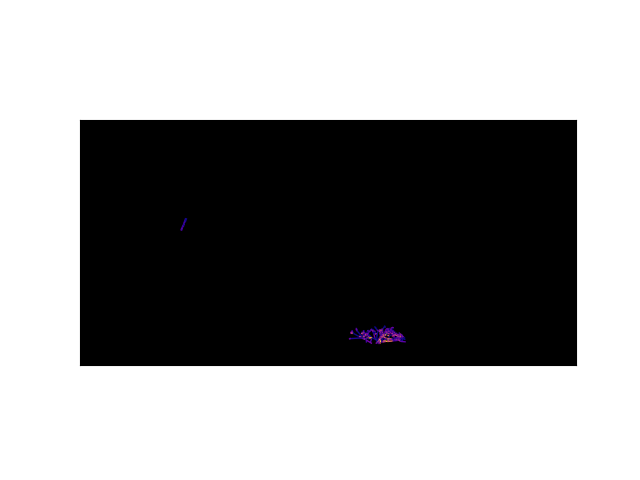

In [10]:
fig,ax = plt.subplots()
rotated_pos = {node: (y, -x) for node, (x, y) in pos.items()}
nx.draw_networkx(
    graph,
    pos=rotated_pos,
    with_labels=False,
    nodelist=[],  # Set the nodes corresponding to the edges
    edgelist=edgelist,
    edge_color=colors,
)
plt.gca().set_aspect('equal')
plt.xlim(0,region[1][1])  # Set x-axis limits
plt.ylim(-region[1][0],0)  # Set y-axis limits
ax.set_facecolor('black')
# plt.savefig(local_file_path,dpi=400)  # Zero-padded for easier sorting


In [ ]:
import geojson
import networkx as nx
def add_positions_to_nodes(G, pos):
    """
    Add 'x' and 'y' position attributes to each node in the graph based on the pos dictionary.
    
    Parameters:
    - G: NetworkX graph to update.
    - pos: Dictionary where each key is a node and each value is a (x, y) tuple.
    """
    for node in G.nodes():
        G.nodes[node]["x"] = np.float64(pos[node][0])
        G.nodes[node]["y"] = np.float64(pos[node][1])
        
def write_graph_to_geojson(G, filename="graph_data.geojson"):
    """
    Write a NetworkX graph with spatial data to a GeoJSON file.
    
    Parameters:
    - G: NetworkX graph with 'x' and 'y' node attributes and a 'pixel_list' edge attribute.
    - filename: Name of the GeoJSON file to save.
    """
    features = []

    # Add nodes as Point features
    for n, data in G.nodes(data=True):
        point = geojson.Point((data['x'], data['y']))  # Assuming 'x' and 'y' represent coordinates
        features.append(geojson.Feature(geometry=point, properties={"id": n, **data}))

    # Add edges as LineString features
    for u, v, data in G.edges(data=True):
        line = data["pixel_list"]
        line = [(np.float64(pixel[0]),float(pixel[1])) for pixel in line]
        line = geojson.LineString(line)
        new_data = {k: np.float64(v) for k, v in data.items() if k != "pixel_list"}
        features.append(geojson.Feature(geometry=line, properties={"source": u, "target": v, **new_data}))

    # Create a FeatureCollection and save
    feature_collection = geojson.FeatureCollection(features)
    with open(filename, "w") as f:
        geojson.dump(feature_collection, f)

def read_graph_from_geojson(filename="graph_data.geojson"):
    """
    Read a GeoJSON file into a NetworkX graph, preserving node and edge attributes.
    
    Parameters:
    - filename: Name of the GeoJSON file to read.

    Returns:
    - G: NetworkX graph with spatial data.
    """
    G = nx.Graph()
    
    with open(filename, "r") as f:
        data = geojson.load(f)

    # Process each feature in the GeoJSON
    for feature in data["features"]:
        if feature["geometry"]["type"] == "Point":
            # Node feature
            node_id = feature["properties"].pop("id")
            x, y = feature["geometry"]["coordinates"]
            # Ensure no duplicate 'x' and 'y' in properties
            feature["properties"].pop("x", None)
            feature["properties"].pop("y", None)
            # Add node with position and other properties
            G.add_node(node_id, x=x, y=y, **feature["properties"])
        elif feature["geometry"]["type"] == "LineString":
            # Edge feature
            source = feature["properties"].pop("source")
            target = feature["properties"].pop("target")
            pixel_list = feature["geometry"]["coordinates"]
            G.add_edge(source, target, pixel_list=pixel_list, **feature["properties"])

    return G

In [ ]:
add_positions_to_nodes(graph, pos)

In [ ]:
write_graph_to_geojson(graph)

In [ ]:
with open(filename, "r") as f:
    data = geojson.load(f)

In [ ]:
G = read_graph_from_geojson()

In [ ]:
fig,ax = plt.subplots()
rotated_pos = {n: (data['y'], -data['x']) for n, data in G.nodes(data=True)}
nx.draw_networkx(
    graph,
    pos=rotated_pos,
    with_labels=False,
    nodelist=[],  # Set the nodes corresponding to the edges
    edgelist=edgelist,
    edge_color=colors,
)
plt.gca().set_aspect('equal')
plt.xlim(0,region[1][1])  # Set x-axis limits
plt.ylim(-region[1][0],0)  # Set y-axis limits
ax.set_facecolor('black')
# plt.savefig(local_file_path,dpi=400)  # Zero-padded for easier sorting


In [ ]:
exp = Experiment(directory_targ)
imin = 344
imax = 347
for i in range(imin,imax):
    exp.load(folders.iloc[i : i + 1], suffix="")    
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)
    region =  [[3500*downsizing,3400*downsizing],[4250*downsizing,4100*downsizing]]
    plot_region(exp,region,0,fig,ax,i,imin,imax)